# MAC0219 - Programação Concorrente, Paralela e Distribuída
# EP2: CUDA & OpenMPI


| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

Neste relatório, vamos explicar...

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

In [6]:
using DataFrames, Query, StatsPlots, Statistics, CSV

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


In [7]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.dimensions,}) |>
                    @map({dimensions = key(_).dimensions,
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

In [8]:
function save_csv_results(parsed_results, name)
    CSV.write(string(name, ".csv"), parsed_results)
end

save_csv_results (generic function with 1 method)

In [9]:
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

# 1. Implementação em CUDA

A implementação em CUDA foi feita tendo como base a versão sequencial, a qual adaptamos para as necessidades da paralelização com computação heterogênea, como é o caso aqui. Nesse sentido, transformamos o método `void compute_mandelbrot()` num método global, pois é este o **Kernel** do programa - isto é, o programa que conecta o _Host_ (CPU) com o _Device_ (GPU). Além disso, deixamos os métodos que são utilizados somente durante o processamento dos pixels (à saber, `int mandelbrot()` e `void update_rgb_buffer()` como exclusivas para o _device_. O restante das conexões entre as duas camadas de memória, do _Host_ e do _Device_ , foi feito manipulando adequadamente a alocação e tráfego de memória quando necessário. 

A divisão de tarefas é feita de maneira estática à partir das dimensões dos _Blocos_ e do _Grid_ no qual estes estão inseridos. Para que pudessemos determinar experimentalmente os melhores valores para essas dimensões, o programa solicita que como argumento (além das coordenadas da região do conjunto e o tamanho da imagem) as dimensões $(x, y)$ dos blocos. À partir desses valores, determina-se também as dimensões do _Grid_ de forma a garantir que a divisão das tarefas contemple toda a imagem a ser gerada. No caso da nossa implementação, isso significa atribuir ao _Grid_ dimensões $(\frac{image\_size}{x}, \frac{image\_size}{y})$. 

Dessa forma, fica estabelicido que cada pixel $(i_x, i_y)$ da imagem será tratado por uma _thread_ de identidade determinada pela sua posição num determinado bloco do grid de acordo com as especificações abaixo:

$$
i_x = blockIdx.x*blockDim.x+threadIdx.x \\
i_y = blockIdx.y*blockDim.y+threadIdx.y
$$

É importante observar um condição de execução importante relavativa a essa implementação: devemos ter, necessariamente, $x * y \leq 1024$. Isto pois ao determinarmos as dimensões dos blocos como sendo $(x, y)$, isso significa que a quantidade de _threads_ em cada bloco é igual a $x * y$, e o limite de $1024$ _threads_ por bloco é uma condição própria do desenvolvimento em CUDA.

Compilação:

In [5]:
;nvcc -gencode arch=compute_50,code=[sm_50,compute_50] mandelbrot_cuda.cu -o mandelbrot -Wno-deprecated-gpu-targets

┌ Warning: Parsing command "nvcc -gencode arch=compute_50,code=[sm_50,compute_50] mandelbrot_cuda.cu -o mandelbrot -Wno-deprecated-gpu-targets". Special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = shell_parse(::String, ::Bool; special::String) at shell.jl:107
└ @ Base ./shell.jl:107


## 1.1 Experimentos com CUDA

Seguindo as instruções do enunciado, os experimentos foram feitos usando os seguintes parâmetros fixos: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**.

Posto isso, o objetivo aqui é realizar experimentos para diferentes valores dos parâmetros $x$ e $y$, que determinam a dimensão dos blocos e do _grid_. Para tanto, determinamos uma região de interesse para esses parâmetros cujo principal critério de escolha foi a limitação de mantermos $x * y \leq 1024$ conforme explicado anteriormente. Nesse sentido, decidimos começar com blocos de dimensao unica (isto é, uma única thread por bloco, implicando num grid com $image\_size * image\_size$ blocos) e irmos dobrando até $(32, 32)$, onde têm-se em cada bloco o limite de $1024$ threads e com _grid_ de dimensão $(128, 128)$. 

A **região de interesse** final, com a qual realizamos os experimentos, é:

**Dimensões dos blocos:** $(1,1)$, $(2,2)$, $(4,4)$, $(8,8)$, $(16,16)$ e $(32,32)$ 

**Respectivas dimensoes do _grid_ :** $(4096, 4096)$, $(2048, 2048)$, $(1024, 1024)$, $(512, 512)$, $(256, 256)$ e $(128, 128)$ 

In [6]:
dimensions = [(2,2),(4,4),(8,8),(16,16),(32,32)]

5-element Array{Tuple{Int64,Int64},1}:
 (2, 2)
 (4, 4)
 (8, 8)
 (16, 16)
 (32, 32)

In [7]:
function mandelbrot_cuda(size, x, y)
    """ Executa o cálculo do conjunto de Mandelbrot na região TripleSpiralValley
        gerando uma imagem de tamanho _size_ fazendo uso da implementação
        em CUDA com blocos de dimensao _(x, y)_ e grid de dimensao _(size/x, size/y)_
    """
    time = parse.(Float64, chomp(read(`./mandelbrot -0.188 -0.012 0.554 0.754 $size $x $y`, String)))
    return DataFrame(dimensions = string(x, ", ", y), duration = time)
end

mandelbrot_cuda (generic function with 1 method)

In [8]:
function run_experiments_cuda(dimensions, size=4096, repetitions=15)
    """ Obtem a duracao dos tempos de execução associado aos cálculos de
        conjunto de Mandelbrot na região TripleSpiralValley à partir da versão 
        paralelizada em CUDA para imagens de tamanho _size_, com uma quantidade
        igual a _repetitions_ de repetições para cada uma das dimensoes de bloco
        (e, por consequencia, de grid) presentes em _dimensions_
    """
    
    results = DataFrame(dimensions = String[], duration = Float64[])    
    
    for x_y in dimensions
        x, y = x_y
        for i in 1:repetitions
            append!(results, mandelbrot_cuda(size, x, y))    
        end
    end
    
    return results
end

run_experiments_cuda (generic function with 3 methods)

In [15]:
results_cuda = run_experiments_cuda(dimensions, 512, 15)
#save_csv_results(results_cuda, "cuda_experiments")

,dimensions,duration
,String,Float64
1,"2, 2",0.280372
2,"2, 2",0.277381
3,"2, 2",0.281127
4,"2, 2",0.277549
5,"2, 2",0.277367
6,"2, 2",0.277539
7,"2, 2",0.277394
8,"2, 2",0.277444
9,"2, 2",0.277479


In [16]:
save_csv_results(results_cuda, "cuda_experiments")
experiments_cuda = read_csv_results("cuda_experiments.csv")
final_results_cuda = parse_results(experiments_cuda)

,dimensions,mean_duration,ci_duration
,String,Float64,Float64
1,"2, 2",0.279893,0.0120944
2,"4, 4",0.0752881,0.00680193
3,"8, 8",0.038103,0.00336642
4,"16, 16",0.0370511,0.00239222
5,"32, 32",0.0382651,0.00401231


# 2. Implementação em OMPI

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Compilação:

In [3]:
;make mandelbrot_ompi

mpicc -o mandelbrot_ompi -lm src/mandelbrot_ompi.c


## 2.1 Experimentos com OMPI

Seguindo as instruções do enunciado, os experimentos foram feitos usando os seguintes parâmetros fixos: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**.

O objetivo é determinar um número ideal $n$ de processos para a implementação através desses experimentos. Definimos a região de interesse conforme sugestão do enunciado, mas sempre tendo pelo menos um processo principal que coletasse os resultados, sendo assim a **região de interesse** com que realizamos os experimentos foi:

**Número de Processos:** $2$,$3$,$5$,$9$,$17$,$33$,$65$


In [14]:
#definir regiao
processes = [2,3,5,9,17,33,65]

7-element Array{Int64,1}:
  2
  3
  5
  9
 17
 33
 65

In [16]:
#funcao pra rodar experimentos nessa regiao
function mandelbrot_ompi(size,n_proc)
    """ Executa o cálculo do conjunto de Mandelbrot na região TripleSpiralValley
        gerando uma imagem de tamanho _size_ fazendo uso da implementação
        em OMPI com _n_proc_ processos.
    """
    time = parse.(Float64, chomp(read(`mpirun -np $n_proc --host localhost:$n_proc mandelbrot_ompi -0.188 -0.012 0.554 0.754 $size`, String)))
    return DataFrame(processes = string(n_proc), duration = time)
end

mandelbrot_ompi (generic function with 1 method)

In [12]:
#funcao pra rodar experimentos nessa regiao
function run_experiments_ompi(process_range, size=4096, repetitions=15)
    """ Obtem a duracao dos tempos de execução associado aos cálculos de
        conjunto de Mandelbrot na região TripleSpiralValley à partir da versão 
        paralelizada em OMPI para imagens de tamanho _size_, com uma quantidade
        igual a _repetitions_ de repetições para cada número de processos em
        _process_range_
    """
    
    results = DataFrame(processes = String[], duration = Float64[])    
    
    for n in process_range
        for i in 1:repetitions
            append!(results, mandelbrot_ompi(size,n))    
        end
    end
    
    return results
end

run_experiments_ompi (generic function with 3 methods)

In [17]:
#rodar os experimentos e salvar em csv 
results_ompi = run_experiments_ompi(processes,256,5) # rodei com um tamanho menor só pra conseguir fazer no meu PC

,processes,duration
,String,Float64
1,2,0.176253
2,2,0.18379
3,2,0.166159
4,2,0.16615
5,2,0.165941
6,3,0.170693
7,3,0.17025
8,3,0.171302
9,3,0.173578


In [22]:
#ler o csv e gerar o parser com medias e CIs
save_csv_results(results_ompi, "ompi_experiments")
experiments_ompi = read_csv_results("ompi_experiments.csv")

# Não sei qual erro está dando
# final_results_ompi = parse_results(experiments_ompi) 

,processes,duration
,Int64,Float64
1,2,0.176253
2,2,0.18379
3,2,0.166159
4,2,0.16615
5,2,0.165941
6,3,0.170693
7,3,0.17025
8,3,0.171302
9,3,0.173578


# 3. Implementação em OMPI + OMP

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Compilação:

In [35]:
;make mandelbrot_ompi_omp

mpicc -o mandelbrot_ompi_omp -lm -fopenmp src/mandelbrot_ompi_omp.c


## 3.1 Experimentos com OMPI + OMP

Seguindo as instruções do enunciado, os experimentos foram feitos usando os seguintes parâmetros fixos: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

**FALAR/JUSTITIFICAR DEFINIÇÃO DA REGIAO DE INTERESSE!**

**Número de Processos:** $2$,$3$,$5$,$9$,$17$,$33$,$65$
**Número de Threads:** $1$,$2$,$4$,$8$,$16$,$32$,$64$


In [38]:
#definir regiao
processes = [2,3,5,9,17,33,65]
threads = [1,2,4,8,16,32,64]

7-element Array{Int64,1}:
  1
  2
  4
  8
 16
 32
 64

In [31]:
#funcao pra rodar experimentos nessa regiao
function mandelbrot_ompi_omp(size,n_proc,n_threads)
    """ Executa o cálculo do conjunto de Mandelbrot na região TripleSpiralValley
        gerando uma imagem de tamanho _size_ fazendo uso da implementação
        em OMPI com _n_proc_ processos.
    """
    time = parse.(Float64, chomp(read(`mpirun -np $n_proc --host localhost:$n_proc mandelbrot_ompi_omp -0.188 -0.012 0.554 0.754 $size $n_threads`, String)))
    return DataFrame(processes = string(n_proc),threads=string(n_threads), duration = time)
end

mandelbrot_ompi_omp (generic function with 1 method)

In [32]:
#funcao pra rodar experimentos nessa regiao
function run_experiments_ompi_omp(process_range,thread_range, size=4096, repetitions=15)
      """ Obtem a duracao dos tempos de execução associado aos cálculos de
        conjunto de Mandelbrot na região TripleSpiralValley à partir da versão 
        paralelizada em OMPI e OMP para imagens de tamanho _size_, com uma quantidade
        igual a _repetitions_ de repetições para cada número de processos em
        _process_range_ e número de threads em _thread_range_.
    """
    
    results = DataFrame(processes = String[],threads=String[], duration = Float64[])    
    
    for n in process_range
        for t in thread_range
            for i in 1:repetitions
                append!(results, mandelbrot_ompi_omp(size,n,t))
            end
        end
    end
    
    return results
end

run_experiments_ompi_omp (generic function with 3 methods)

In [39]:
#rodar os experimentos e salvar em csv 
results_ompi_omp = run_experiments_ompi_omp(processes,threads,256,5)

--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpirun noticed that process rank 0 with PID 0 on node localhost exited on signal 11 (Segmentation fault).
--------------------------------------------------------------------------


ProcessFailedException: failed process: Process(`mpirun -np 5 --host localhost:5 mandelbrot_ompi_omp -0.188 -0.012 0.554 0.754 256 2`, ProcessExited(139)) [139]


In [ ]:
#ler o csv e gerar o parser com medias e CIs
save_csv_results(results_ompi_omp, "ompi_omp_experiments")
experiments_ompi_omp = read_csv_results("ompi_omp_experiments.csv")
final_results_ompi_omp = parse_results(experiments_ompi_omp) 

# 4. Implementação em OMPI + CUDA

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Compilação:

## 4.1 Experimentos com OMPI + CUDA

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

**FALAR/JUSTITIFICAR DEFINIÇÃO DA REGIAO DE INTERESSE!**

In [ ]:
#definir regiao

In [ ]:
#funcao pra rodar experimentos nessa regiao

In [ ]:
#funcao pra rodar experimentos nessa regiao

In [32]:
#rodar os experimentos e salvar em csv 

In [ ]:
#ler o csv e gerar o parser com medias e CIs

# 5. Análise dos resultados dos experimentos

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Faremos uso das duas funções abaixo para gerar os gráficos sobre os quais analisaremos cada caso:

In [21]:
function plot_results_scatter(x, xlabel_, ylabel_, title_,
                        y1, series_label, yerror1)  
    p = plot(x,        
            y1,
            yerror = yerror1,
            alpha = 0.9,
            labels = series_label,
            xlabel = xlabel_,
            ylabel = ylabel_,
            title = title_,
            color = "red",
            seriestype = :scatter,
            lw = 1,
            legend = :topright)
    return p
end

plot_results_scatter (generic function with 1 method)

In [27]:
#implementar função pra gear grafico de todos os pontos
function plot_results(x, y, series_label, xlabel_, ylabel_, title_)      
    p = scatter(x, y,
            alpha = 0.6,
            labels = series_label,
            xlabel = xlabel_,
            ylabel = ylabel_,
            title = title_,
            legend = :topright)
    return p
end



plot_results (generic function with 2 methods)

## 5.1 Resultados da versão CUDA

[ANALISE GERAL]

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.


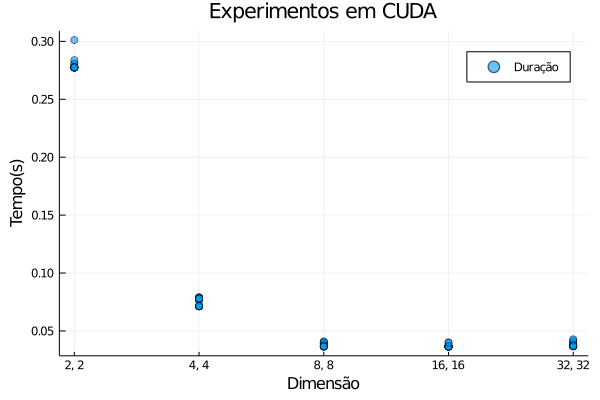

In [29]:
#plotar graficos com todos os pontos


plot_results(results_cuda.dimensions,
    results_cuda.duration,    
    "Duração", "Dimensão", "Tempo(s)", "Experimentos em CUDA")



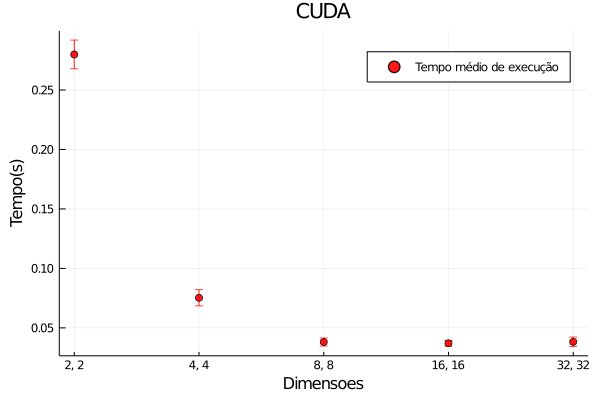

In [30]:
plot_results_scatter(final_results_cuda.dimensions, "Dimensoes", "Tempo(s)", "CUDA",
                     final_results_cuda.mean_duration, "Tempo médio de execução", 
                    final_results_cuda.ci_duration)

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS!**

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

## 5.2 Resultados da versão OMPI

[ANALISE GERAL]

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.


In [ ]:
#plotar graficos com todos os pontos

In [40]:
#plotar graficos com tempo medio e intervalo de confiança

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

## 5.3 Resultados da versão OMPI + OMP

[ANALISE GERAL]

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.


In [ ]:
#plotar graficos com todos os pontos

In [40]:
#plotar graficos com tempo medio e intervalo de confiança

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

## 5.4 Resultados da versão OMPI + CUDA

[ANALISE GERAL]

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.


In [ ]:
#plotar graficos com todos os pontos

In [40]:
#plotar graficos com tempo medio e intervalo de confiança

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

# 6. Comparação entre as diferentes versões

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

In [ ]:
#plotar graficos!!!

In [ ]:
#plotar graficos!!!

In [41]:
#plotar graficos!!!

***Usando os parâmetros determinados na seção anterior, comparar os desempenhos das seguintes versões do programa basenado-se nos graficos!!!!***

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

# 7. Conclusão

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.